This notebook is forked from **Astandri K**'s original notebook (100% credit to him):
https://www.kaggle.com/astandrik/journey-from-statistics-eda-to-prediction

I added a few points below to enhance my personal understanding so this notebook is meant as a supplement to **Astandri K**'s work above:
* **D.1 Filling Missing Values in Age**: added box plots for median, and emphasized the use of median as a more appropriate measure of central tendency, given the age distribution skew
* **G.3 Model Performance**: added Confusion Matrix, Accuracy, Recall and Precision scores for greater clarity on measuring model performance, which are applicable for a binary classification problem such as this

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.
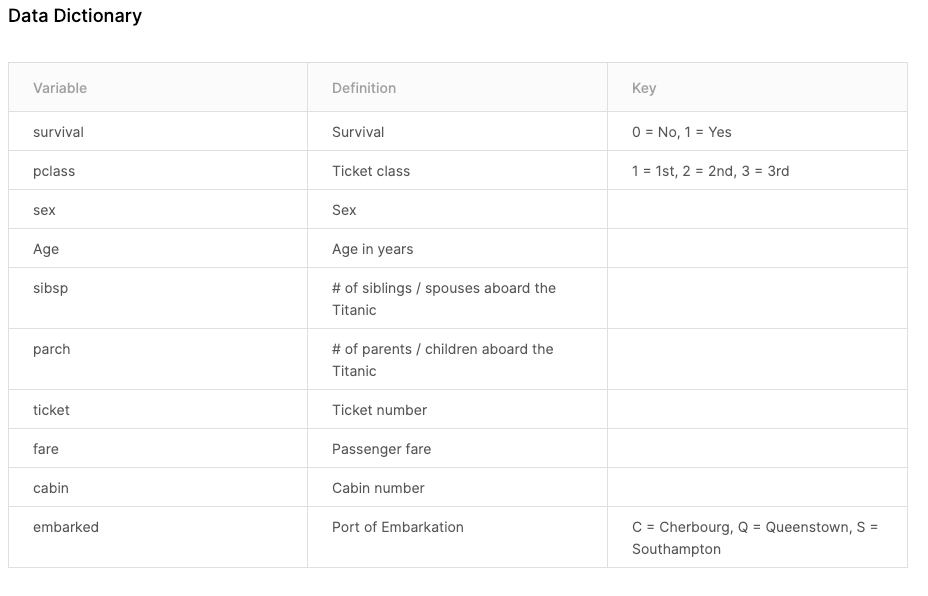
	

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [5]:
# Initialize Notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Normalizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

**IMPORT DATASET**

1st of all, let's import the dataset:

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
train.shape, test.shape

((891, 12), (418, 11))

# **NOTEBOOK OUTLINE** <br>

# A. Descriptive Statistics <br>
# B. Exploratory Data Analysis (EDA) <br>
# C. Summary and Feature Selection <br>
# D. Dealing with Missing Values <br>
# E. Feature Engineering <br>
# F. Final Data Preparation <br>
# G. Prediction (Modelling) <br>

**A. DESCRIPTIVE STATISTICS**

All right, using a few lines of code, let's try to describe the data using descriptive statistics:

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


**A.1 Numerical Attributes**

From the codes above, we obtain the descriptive statistics for numerical attributes: **What do we see here?**
1. **Survived**: The sample mean of this training data is 0,38, which could means *only about that percentage of passengers survived from titanic accident*

2. **Pclass** (Passenger Class:Tthere are 3 class of passenger. At Q2(50%) and Q3(75%) we could see the value is 3, which could means *there are minimum 50% (or more) passengers which is 3rd class passengers*. It seems logical since lower class usually have cheaper ticket prize, and more quota for that class

3. **Age**: From train and test data, the count values seems different from the others. yes, **Age attribute contains missing values**. Another useful information, the mean/average age on training data is 29 years old, which is 1 years older than the median value of the mean (30 mean and 27 median on test dataset), so what does it mean?
    
    It means the distributions of age values have **right skew**, which we expect some outliers in the *higher age value* (on the right size ofthe axis. As we can see, on the training and test dataset max value is 80 and 76 respectively.
    
4. **SibSp and Parch**: These attributes indicate number of SIblings or spouses, and Parent or Children number aboard. From the mean value, seems *majority of the passengers is alone (neither have SibSp or Parch)*. It is interesting that we see the maximum value have 8 SibSp and 9 ParCh, *maybe the oldest person brought his/her entire family on the ship*

5. **Fare**: There are huge difference between mean and median value of this attributes, which is logical. *Many passengers from 3rd class which always have lower Fare*, on the other hand, we have so high value on max of Fare here, which seems an outlier that affect the average of this attributes (**again, right skew**). **Fare attribute contain 1 missing value on test dataset**

In [12]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",male,1601,G6,S
freq,1,577,7,4,644


In [13]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Sage, Master. William Henry",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


**A.2 Categorical Attributes** <br>
Now, we're dealing with categorical attributes. From the describe method above, we get additional information:
1. **Name**: All names are unique (nothing special), *but they contains title*. maybe we can do some feature engineering later to get new attributes which could improve our prediction later.

2.  **Sex**: Or *gender*. Consists of 2 categories - male and female. In both training and test datasets, male have higher frequency (approximately 60:40.)

3.  **Ticket**: There are many unique values for this attributes - maybe we'll just drop this attribute for now and include it for future research

4. **Cabin**: Many **missing values** here (*204 filled from 891 possible* on training dataset and *91 filled from 418 possible* on test dataset). *Maybe some passengers*, which we already know, 3rd Class or low-Fare passengers **don't have Cabin**.

5. **Embarked**: There are **2 missing values** on training dataset. From the train and test datasets, we know that most passengers embarked from S (*what's "S" anyway?*)

**B. EXPLORATORY DATA ANALYSIS (EDA)**

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train.dropna()
train.shape

(891, 12)

**Plot Charts**

Text(0.5, 1.0, 'Survival Rate by Embarked')

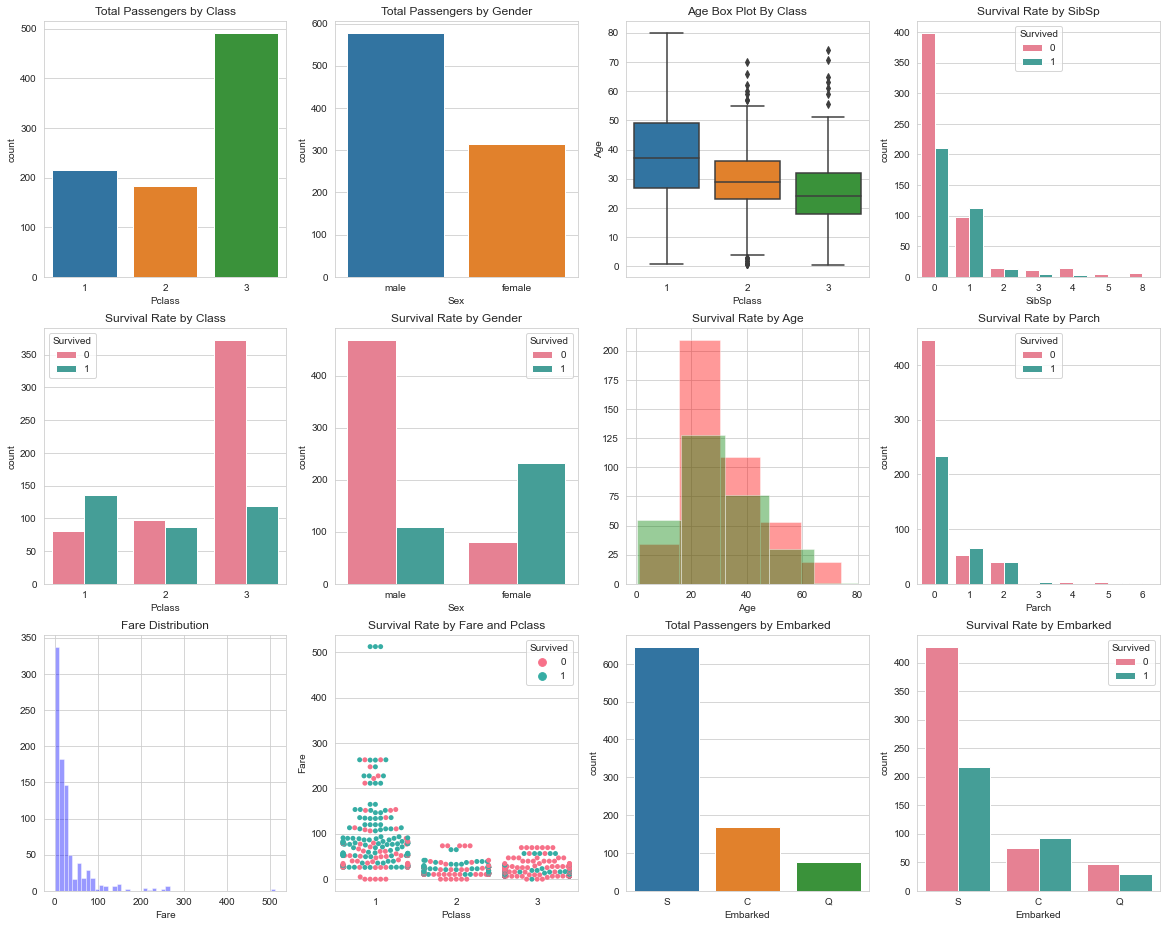

In [16]:
f,ax = plt.subplots(3,4,figsize=(20,16))
sns.countplot('Pclass',data=train,ax=ax[0,0])
sns.countplot('Sex',data=train,ax=ax[0,1])
sns.boxplot(x='Pclass',y='Age',data=train,ax=ax[0,2])
sns.countplot('SibSp',hue='Survived',data=train,ax=ax[0,3],palette='husl')
sns.distplot(train['Fare'].dropna(),ax=ax[2,0],kde=False,color='b')
sns.countplot('Embarked',data=train,ax=ax[2,2])

sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1,0],palette='husl')
sns.countplot('Sex',hue='Survived',data=train,ax=ax[1,1],palette='husl')
sns.distplot(train[train['Survived']==0]['Age'].dropna(),ax=ax[1,2],kde=False,color='r',bins=5)
sns.distplot(train[train['Survived']==1]['Age'].dropna(),ax=ax[1,2],kde=False,color='g',bins=5)
sns.countplot('Parch',hue='Survived',data=train,ax=ax[1,3],palette='husl')
sns.swarmplot(x='Pclass',y='Fare',hue='Survived',data=train,palette='husl',ax=ax[2,1])
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[2,3],palette='husl')

ax[0,0].set_title('Total Passengers by Class')
ax[0,1].set_title('Total Passengers by Gender')
ax[0,2].set_title('Age Box Plot By Class')
ax[0,3].set_title('Survival Rate by SibSp')
ax[1,0].set_title('Survival Rate by Class')
ax[1,1].set_title('Survival Rate by Gender')
ax[1,2].set_title('Survival Rate by Age')
ax[1,3].set_title('Survival Rate by Parch')
ax[2,0].set_title('Fare Distribution')
ax[2,1].set_title('Survival Rate by Fare and Pclass')
ax[2,2].set_title('Total Passengers by Embarked')
ax[2,3].set_title('Survival Rate by Embarked')

> Some useful information:
* Clearly, we can see most passengers are in class 3, which have least survival probability here
* From Sex attribute, we can see total male Passengers is almost 2 times of female passengers, but lower survival probability *maybe male passengers tend to save their lady first?*
* From the figure above, we can try to input missing ages by class:
    * Pclass 1, median Age is approximately = 37
    * Pclass 2, median Age is approximately = 29
    * Pclass 3, median Age is approximately = 24
* Ages have right-skewed distributions so median is a better measure of central tendency than mean
* It seems that passengers with Sibling/Spouse or have Parent/Children aboard, have higher survival rates than passengers who are alone!

In [17]:
train['Cabin'].value_counts().head()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
E101           3
Name: Cabin, dtype: int64

Now we have new information - some passengers have multiple cabin listed.
For each passenger, I'll just try to create a new feature called **'Deck'** with the first letter from the Cabin as its value.
If a passenger have multiple deck listed, I'll just use the higher class deck (ex: A and D, I'll just use A as the value.)

Thanks to this discussion: https://www.kaggle.com/c/titanic/discussion/4693

"First class had the top decks (A-E), second class (D-F), and third class (E-G). It also makes sense that the people towards the top (higher decks, higher pclass) more likely survived, because they were closer to the lifeboats."

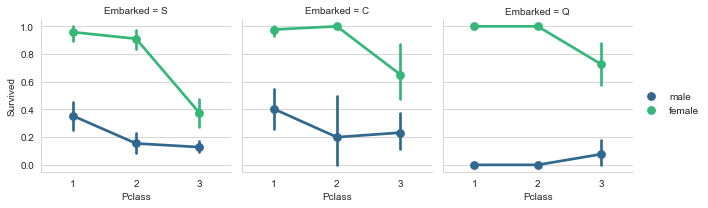

In [18]:
g = sns.FacetGrid(col='Embarked',data=train)
g.map(sns.pointplot,'Pclass','Survived','Sex',palette='viridis',hue_order=['male','female'])
g.add_legend()

Information from visualizations above:
* Female passengers who embarked from C and Q have high survival rate
* Female passengers who embarked from Queenstown in Class 1 and 2 all survived!
* Male passengers who embarked from Queenstown in Class 1 and 2 have the lowest survival rate!

**C. SUMMARY**

This is a summary of our dataset and plan:
* **Survived:**
    * The value we should predict using test dataset. It is numerical with binary value 0 (Dead) and 1 (Survived)
    
* **Pclass:**
    * The data type is categorical, level of measurement is qualitative->ordinal, since the level seems like 1>2>3.
    * Since this is an ordinal, maybe we should **scale its value from 0 to 1** so we can keep the level information from this variable.
    
* **Name:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * We should include this variable in **Feature Engineering** process to extract the title value which maybe could improve our prediction result.
    
* **Sex:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * Since this is a categorical, maybe we should change the value to binary value 0 for male and 1 for female. We'll do this on **Data Preparation** process.
    
* **Age:**
    * The data type is numerical->continuous with level of measurement quantitative->ratio.
    * We should fill the **missing values**
    * For a more meaningful analysis on age, it's better to change the level of measurement to quantitative->interval, by grouping the ages (maybe 1. Children/ Teenagers, 2. Young adults, 3. Adults, 4. Middle-aged and 5. Seniors) in the **Feature Engineering** process.
    * Ages have right-skewed distributions so median is a better measure of central tendency than mean
    
* **SibSp & Parch:**
    * The data type is numerical, level of measurement is quantitative->ratio.
    * Passenger with Sibling/Spouse, or have parent/children aboard, have higher survival rate than passenger which is alone!
    * So I'll create a new feature based on this attribute called 'is_alone', I'll do this on **Feature engineering** process.
    
* **Ticket:**
    * *Let's drop this for now.*
    
* **Fare:**
    * The data type is numerical->continuous with level of measurement is quantitative->ratio.
    * There is 1 missing value in test dataset
    * Since it seems there is an increasing level of passenger based on the Fare, I'll just scale the value of this variable from 0 to 1 in **Feature Engineering** process.
    
* **Cabin:**
    * The data type is categorical, level of measurement is qualitative->ordinal, since the level seems like A>B>C>D..
    * Some passenger have multiple cabin listed.
    * There are many **missing values** on this attributes, I'll fill it with 'No Cabin' string.
    * For each passenger, I'll just try to create a new feature called **'Deck'** with first letter from the Cabin as its value on **Feature Engineering** process.
    * If passenger have multiple deck listed, I'll just use the higher class deck (ex: A and D, I'll just use A as the value)
    * Because this variable is ordinal, I'll further change the letter value to be scaled from 0 to 1 in **Feature Engineering** process
    
* **Embarked:**
    * The data type is categorical, level of measurement is qualitative->nominal.
    * Since this is a categorical, maybe we should **get dummies** of this variable.
    * There are 2 missing values in training dataset

**D. DEALING WITH MISSING VALUES**

From the summary above, we should fill missing values in **Age**, 1 value for **Fare** in test, and 2 values for **Embarked** in training. So, let's do this.

Hang on, let's check the missing values using heatmap:

<AxesSubplot:>

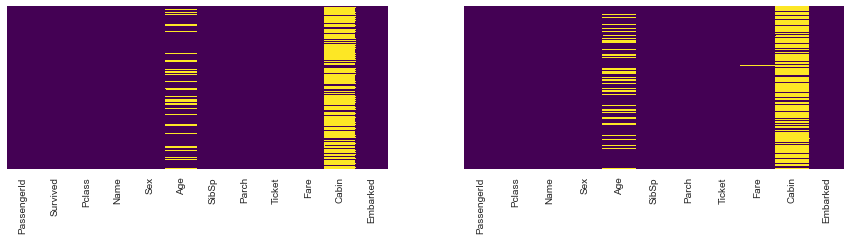

In [19]:
f,ax = plt.subplots(1,2,figsize=(15,3))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[0])
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[1])

**D.1 Filling missing values in Age**

Let's look at the box plots 1st:

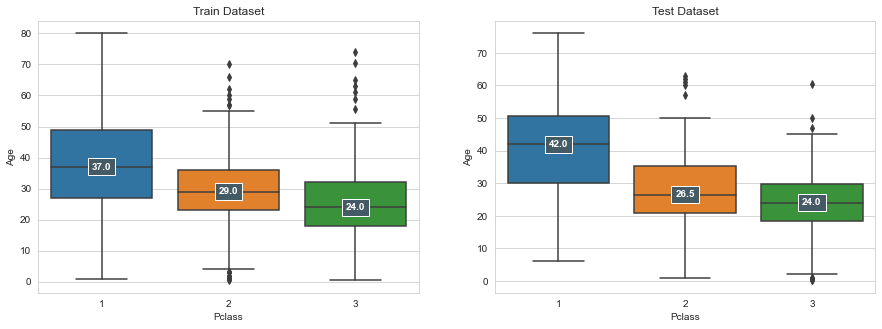

In [20]:
# Set Figure Size
fig = plt.figure(figsize=(15,5))

# 1st Subplot
ax = fig.add_subplot(1, 2, 1)

# Box Plot for Age by Pclass for Train Data
ax.set_title('Train Dataset')

# Settings to display median values
box_plot_train = sns.boxplot(x='Pclass',y='Age',data=train)
ax_train = box_plot_train.axes
lines_train = ax_train.get_lines()
categories_train = ax_train.get_xticks()

for cat in categories_train:
    # Median line is the 4th line in a range of 6 lines:
    # 0: 25th percentile, 1: 75th percentile, 2: lower whisker, 3: upper whisker, 4: median, 5: upper extreme value
    y = round(lines_train[4+cat*6].get_ydata()[0],1) 

    ax_train.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold',
                  size=10, color='white', bbox=dict(facecolor='#445A64'))

# 2nd Subplot
ax = fig.add_subplot(1, 2, 2)

# Box Plot for Age by Pclass for Test Data
ax.set_title('Test Dataset')

# Settings to display median values
box_plot_test = sns.boxplot(x='Pclass',y='Age',data=test)
ax_test = box_plot_test.axes
lines_test = ax_test.get_lines()
categories_test = ax_test.get_xticks()

for cat in categories_test:
    # Median line is the 4th line in a range of 6 lines:
    # 0: 25th percentile, 1: 75th percentile, 2: lower whisker, 3: upper whisker, 4: median, 5: upper extreme value
    y = round(lines_test[4+cat*6].get_ydata()[0],1) 

    ax_test.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold',
                  size=10, color='white', bbox=dict(facecolor='#445A64'))


In [21]:
test.groupby('Pclass')['Age'].median()

Pclass
1    42.0
2    26.5
3    24.0
Name: Age, dtype: float64

<AxesSubplot:title={'center':'Test Dataset'}, xlabel='Age'>

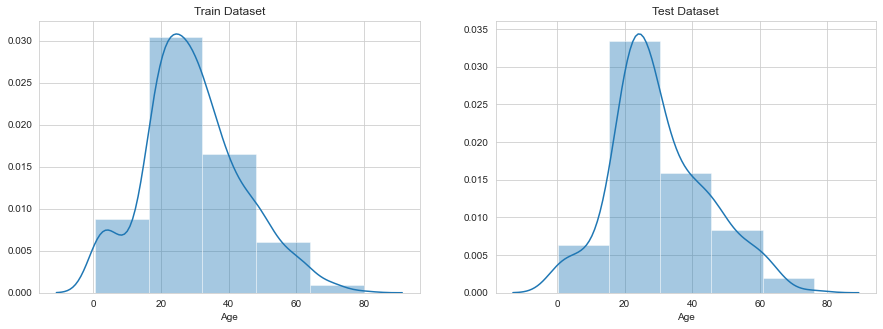

In [22]:
# Histograms for Age

# Set Figure Size
fig = plt.figure(figsize=(15,5))

# 1st Subplot
ax = fig.add_subplot(1, 2, 1)

# Histogram for Age: Train Dataset
ax.set_title('Train Dataset')

sns.distplot(train['Age'].dropna(), kde=True, bins=5)

# 2nd Subplot
ax = fig.add_subplot(1, 2, 2)

# Histogram for Age: Test Dataset
ax.set_title('Test Dataset')

sns.distplot(test['Age'].dropna(), kde=True, bins=5)


From the box plots above, we can fill missing Ages with:
* Train: PClass 1 = 37, PClass 2 = 29, PClass 3 = 24
* Test: PClass 1 = 42, PClass 2 = 26.5, PClass 3 = 24

And from the histograms above, Ages clearly have right-skewed distributions so median is a better measure of central tendency than mean. This is very similar to income distributions, which are also skewed to the right, such that mean will overstate the feature's "centralness" while mode will understate the centralness.

![](https://www.statisticshowto.com/wp-content/uploads/2014/02/pearson-mode-skewness.jpg)

In [23]:
def fill_age_train(cols):
    Age = cols[0]
    PClass = cols[1]
    
    if pd.isnull(Age):
        if PClass == 1:
            return 37
        elif PClass == 2:
            return 29
        else:
            return 24
    else:
        return Age

def fill_age_test(cols):
    Age = cols[0]
    PClass = cols[1]
    
    if pd.isnull(Age):
        if PClass == 1:
            return 42
        elif PClass == 2:
            return 26.5
        else:
            return 24
    else:
        return Age

In [24]:
train['Age'] = train[['Age','Pclass']].apply(fill_age_train,axis=1)
test['Age'] = test[['Age','Pclass']].apply(fill_age_test,axis=1)

**D.2 Filling Missing Values in Fare, Cabin and Embarked**

In [25]:
test['Fare'].fillna(stat.mode(test['Fare']),inplace=True)
train['Embarked'].fillna('S',inplace=True)
train['Cabin'].fillna('No Cabin',inplace=True)
test['Cabin'].fillna('No Cabin',inplace=True)

<AxesSubplot:>

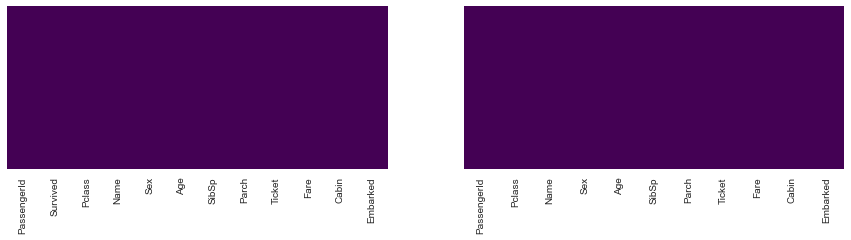

In [26]:
f,ax = plt.subplots(1,2,figsize=(15,3))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[0])
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax[1])

**ALL CLEARED NOW!** Ready for feature engineering, after we drop Ticket:

In [27]:
train.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,No Cabin,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,No Cabin,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,No Cabin,S


In [29]:
train["Name"][20]

'Fynney, Mr. Joseph J'

**E. FEATURE ENGINEERING**

As mentioned in the Summary section above, we will work on **Name, Age, SibSP & Parch, Fare, Cabin**: let's do this!

In [30]:
# Combine Dataset 1st for Feature Engineering

train['IsTrain'] = 1
test['IsTrain'] = 0
df = pd.concat([train,test])

In [31]:
# Scaler Initiation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

**E.1 Feature Engineering: Name -> Title**

In [32]:
df['Title'] = df['Name'].str.split(', ').str[1].str.split('.').str[0]
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Capt              1
Dona              1
Jonkheer          1
Sir               1
the Countess      1
Mme               1
Don               1
Lady              1
Name: Title, dtype: int64

For these rare title, we'll convert them to 'Others', except **Mme** will be converted to Mrs, **Ms and Mlle** to Miss

In [33]:
df['Title'].replace('Mme','Mrs',inplace=True)
df['Title'].replace(['Ms','Mlle'],'Miss',inplace=True)
df['Title'].replace(['Dr','Rev','Col','Major','Dona','Don','Sir','Lady','Jonkheer','Capt','the Countess'],'Others',inplace=True)
df['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Others     29
Name: Title, dtype: int64

In [34]:
df.drop('Name',axis=1,inplace=True)
df.head()

,Age,Cabin,Embarked,Fare,IsTrain,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,No Cabin,S,7.2500,1,0,1,3,male,1,0.0,Mr
1,38.0,C85,C,71.2833,1,0,2,1,female,1,1.0,Mrs
2,26.0,No Cabin,S,7.9250,1,0,3,3,female,0,1.0,Miss
3,35.0,C123,S,53.1000,1,0,4,1,female,1,1.0,Mrs
4,35.0,No Cabin,S,8.0500,1,0,5,3,male,0,0.0,Mr


**E.2 Feature Engineering: Age -> AgeGroup**

<AxesSubplot:xlabel='Age'>

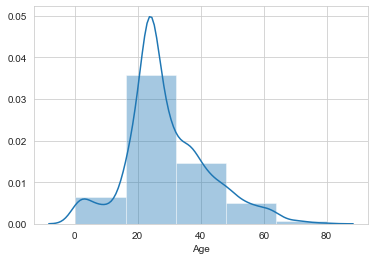

In [35]:
sns.distplot(df['Age'],bins=5)

I'll divide the ages to 5 categories: Children (<=19), Young Adults (>19, <=30), Adults (>30, <=45), Middle Aged (>45, <=63), Seniors (>63), 

with: **Children = 0, Young Adults = 1, Adults = 2, Middle Aged = 3, Seniors = 4**

In [36]:
df['AgeGroup'] = df['Age']
df.loc[df['AgeGroup']<=19, 'AgeGroup'] = 0
df.loc[(df['AgeGroup']>19) & (df['AgeGroup']<=30), 'AgeGroup'] = 1
df.loc[(df['AgeGroup']>30) & (df['AgeGroup']<=45), 'AgeGroup'] = 2
df.loc[(df['AgeGroup']>45) & (df['AgeGroup']<=63), 'AgeGroup'] = 3
df.loc[df['AgeGroup']>63, 'AgeGroup'] = 4

<AxesSubplot:xlabel='AgeGroup', ylabel='count'>

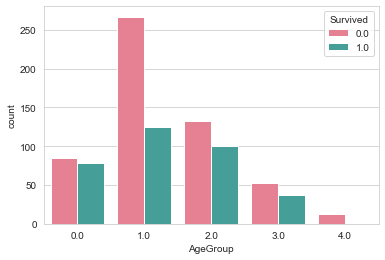

In [37]:
sns.countplot(x='AgeGroup',hue='Survived',data=df[df['IsTrain']==1],palette='husl')

In [38]:
df.drop('Age',axis=1,inplace=True)
df.head()

,Cabin,Embarked,Fare,IsTrain,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,AgeGroup
0,No Cabin,S,7.2500,1,0,1,3,male,1,0.0,Mr,1.0
1,C85,C,71.2833,1,0,2,1,female,1,1.0,Mrs,2.0
2,No Cabin,S,7.9250,1,0,3,3,female,0,1.0,Miss,1.0
3,C123,S,53.1000,1,0,4,1,female,1,1.0,Mrs,2.0
4,No Cabin,S,8.0500,1,0,5,3,male,0,0.0,Mr,2.0


**E.3 Feature Engineering: SibSp & Parch -> IsAlone**

In [39]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 #himself
df['IsAlone'] = 0
df.loc[df['FamilySize']==1, 'IsAlone'] = 1

<AxesSubplot:xlabel='IsAlone', ylabel='count'>

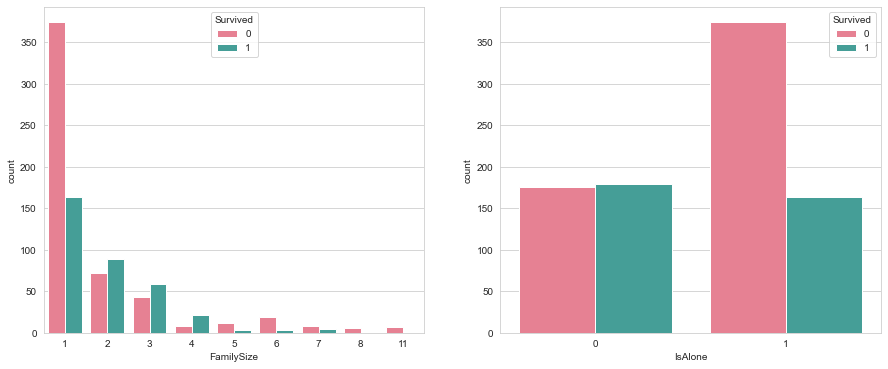

In [40]:
# Visual Inspection of Survival Rates

f,ax = plt.subplots(1,2,figsize=(15,6))
sns.countplot(df[df['IsTrain']==1]['FamilySize'],hue=train['Survived'],ax=ax[0],palette='husl')
sns.countplot(df[df['IsTrain']==1]['IsAlone'],hue=train['Survived'],ax=ax[1],palette='husl')


From the figures above, we can see that if a passenger has family onboard, **the survival rate will increase to approximately 50%.**

Since we already have the information using IsAlone feature only, *we'll just drop SibSp, Parch, and FamilySize*

In [41]:
df.drop(['SibSp','Parch','FamilySize'],axis=1,inplace=True)
df.head()

,Cabin,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone
0,No Cabin,S,7.2500,1,1,3,male,0.0,Mr,1.0,0
1,C85,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0
2,No Cabin,S,7.9250,1,3,3,female,1.0,Miss,1.0,1
3,C123,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0
4,No Cabin,S,8.0500,1,5,3,male,0.0,Mr,2.0,1


In [42]:
df.head()

,Cabin,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone
0,No Cabin,S,7.2500,1,1,3,male,0.0,Mr,1.0,0
1,C85,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0
2,No Cabin,S,7.9250,1,3,3,female,1.0,Miss,1.0,1
3,C123,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0
4,No Cabin,S,8.0500,1,5,3,male,0.0,Mr,2.0,1


**E.4 Feature Engineering: Cabin -> Deck**

In [43]:
df['Deck'] = df['Cabin']
df.loc[df['Deck']!='No Cabin','Deck'] = df[df['Cabin']!='No Cabin']['Cabin'].str.split().apply(lambda x: np.sort(x)).str[0].str[0]
df.loc[df['Deck']=='No Cabin','Deck'] = 'N/A'

<AxesSubplot:xlabel='Deck', ylabel='count'>

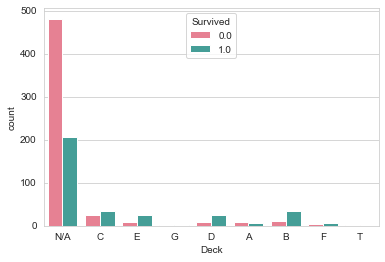

In [44]:
sns.countplot(x='Deck',hue='Survived',data=df[df['IsTrain']==1],palette='husl')

Well, now we can clearly see the survival rate based on passenger's Deck

In [45]:
df.loc[df['Deck']=='N/A', 'Deck'] = 0
df.loc[df['Deck']=='G', 'Deck'] = 1
df.loc[df['Deck']=='F', 'Deck'] = 2
df.loc[df['Deck']=='E', 'Deck'] = 3
df.loc[df['Deck']=='D', 'Deck'] = 4
df.loc[df['Deck']=='C', 'Deck'] = 5
df.loc[df['Deck']=='B', 'Deck'] = 6
df.loc[df['Deck']=='A', 'Deck'] = 7
df.loc[df['Deck']=='T', 'Deck'] = 0

In [46]:
df.drop('Cabin',axis=1,inplace=True)
df.head()

,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone,Deck
0,S,7.2500,1,1,3,male,0.0,Mr,1.0,0,0
1,C,71.2833,1,2,1,female,1.0,Mrs,2.0,0,5
2,S,7.9250,1,3,3,female,1.0,Miss,1.0,1,0
3,S,53.1000,1,4,1,female,1.0,Mrs,2.0,0,5
4,S,8.0500,1,5,3,male,0.0,Mr,2.0,1,0


**E.5 Feature Engineering -> Scaling**

In this part, any features with level of measurement nominal -> ordinal would be scaled from 0 to 1: they are **Fare, Pclass, and Deck**:

In [47]:
df[['Fare','Pclass','Deck']] = scaler.fit_transform(df[['Fare','Pclass','Deck']])

In [48]:
df.head()

,Embarked,Fare,IsTrain,PassengerId,Pclass,Sex,Survived,Title,AgeGroup,IsAlone,Deck
0,S,0.014151,1,1,1.0,male,0.0,Mr,1.0,0,0.000000
1,C,0.139136,1,2,0.0,female,1.0,Mrs,2.0,0,0.714286
2,S,0.015469,1,3,1.0,female,1.0,Miss,1.0,1,0.000000
3,S,0.103644,1,4,0.0,female,1.0,Mrs,2.0,0,0.714286
4,S,0.015713,1,5,1.0,male,0.0,Mr,2.0,1,0.000000


**F. FINAL DATA PREPARATION**

We now have all the features. Finally, on data preprocessing, we need to create dummies for categorical data and produce a new DataFrame. The features to preprocess are: **Embarked, Sex, Title, AgeGroup**.

In [49]:
def process_dummies(df,cols):
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col,drop_first=True)
        df = pd.concat([df.drop(col,axis=1),dummies],axis=1)
    return df

In [50]:
df = process_dummies(df,['Embarked','Sex','Title','AgeGroup'])

In [51]:
df.head()

,Fare,IsTrain,PassengerId,Pclass,Survived,IsAlone,Deck,Embarked_Q,Embarked_S,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others,AgeGroup_1.0,AgeGroup_2.0,AgeGroup_3.0,AgeGroup_4.0
0,0.014151,1,1,1.0,0.0,0,0.000000,0,1,1,0,1,0,0,1,0,0,0
1,0.139136,1,2,0.0,1.0,0,0.714286,0,0,0,0,0,1,0,0,1,0,0
2,0.015469,1,3,1.0,1.0,1,0.000000,0,1,0,1,0,0,0,1,0,0,0
3,0.103644,1,4,0.0,1.0,0,0.714286,0,1,0,0,0,1,0,0,1,0,0
4,0.015713,1,5,1.0,0.0,1,0.000000,0,1,1,0,1,0,0,0,1,0,0


In [52]:
len(df["Survived"])

1309

**F.1 Divide df to train dataset and holdout for final testing purpose**

Before we continue to the prediction section, let's divide our data again to **dataset** (formerly train data) and **holdout** (formerly test data):

In [53]:
dataset = df[df['IsTrain']==1]
dataset.drop(['IsTrain','PassengerId'],axis=1,inplace=True)
holdout = df[df['IsTrain']==0]
test_id = holdout['PassengerId']
holdout.drop(['IsTrain','PassengerId','Survived'],axis=1,inplace=True)

In [54]:
X =  dataset
train_columns = X.columns
Y = dataset["Survived"]
X.drop(['Survived'],axis=1,inplace=True)


X_test = holdout

print(X.shape,Y.shape,X_test.shape)
print (X.columns)
print(X_test.columns)

(891, 15) (891,) (418, 15)
Index(['Fare', 'Pclass', 'IsAlone', 'Deck', 'Embarked_Q', 'Embarked_S',
       'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Others',
       'AgeGroup_1.0', 'AgeGroup_2.0', 'AgeGroup_3.0', 'AgeGroup_4.0'],
      dtype='object')
Index(['Fare', 'Pclass', 'IsAlone', 'Deck', 'Embarked_Q', 'Embarked_S',
       'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Others',
       'AgeGroup_1.0', 'AgeGroup_2.0', 'AgeGroup_3.0', 'AgeGroup_4.0'],
      dtype='object')


## XGBOOST

In [55]:
# !pip install xgboost

In [56]:
import xgboost as xgb
model = xgb.XGBClassifier()

In [59]:
model.fit(X, Y)  
Y_pred = model.predict(X_test)  
acc_tree = round(model.score(X, Y) * 100, 2)
acc_tree

[21:34:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




94.05

## grid search cv

In [60]:
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

clf = xgb.XGBClassifier()
tree_search = GridSearchCV(clf, gbm_param_grid, scoring='average_precision')


tree_search.fit(X,Y)

print("Tree best parameters :",tree_search.best_params_)
print("Tree best estimator :",tree_search.best_estimator_ )
print("Tree best score :",tree_search.best_score_ )

Tree best parameters : {'colsample_bytree': 0.8, 'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 10}
Tree best estimator : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Tree best score : 0.8595157632100718


In [63]:
tree_best_parameters = tree_search.best_params_
tree_optimized = xgb.XGBClassifier(**tree_best_parameters)
tree_optimized.fit(X,Y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:

prediction_values = tree_optimized.predict(X_test).astype(int)
prediction = pd.DataFrame({"PassengerId":test_id,
                           "Survived":prediction_values})

prediction.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


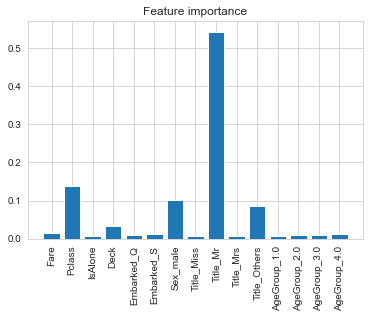

In [65]:
train_columns = list(X.columns)
fig, ax = plt.subplots( figsize=(6,4))
ax.bar(range(len(X.columns)),tree_optimized.feature_importances_ )
plt.xticks(range(len(X.columns)),X.columns,rotation=90)
ax.set_title("Feature importance")
plt.show()


In [ ]:
#https://developers.google.com/machine-learning/crash-course/ml-intro

In [61]:
# Next class
# linear regression
# logistic regression
#https://www.kaggle.com/shreayan98c/boston-house-price-prediction